In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
#nltk.download('punkt')
from nltk.util import ngrams, bigrams, everygrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten, pad_both_ends
from nltk.lm import NgramCounter, MLE
from collections import defaultdict, Counter
from collections.abc import Sequence
from nltk.probability import FreqDist, ConditionalFreqDist
from math import log2

#[*pad_sequence(next(fx),n=5,pad_left=True,left_pad_symbol="</s>", pad_right=True, right_pad_symbol="</s>")]
#list(pad_both_ends(next(fx),n=3))
#list(everygrams(pad_both_ends(next(fx),n=2),max_len=2))
#list(flatten(pad_both_ends(text,n=3) for text in fx))


from collections import defaultdict
from collections.abc import Sequence
from nltk.probability import FreqDist, ConditionalFreqDist

In [2]:
#preprocessing
def replace(text:str):
    replacement_rules = {'“': '"', '”': '"', '’': "'", '--': ','}
    for key,val in replacement_rules.items():
        text.replace(key,val)
    return text
def tok_sent(paragrah:str):
    word_tok= RegexpTokenizer(r'[-\'\w]+',gaps=False)
    for sentence in sent_tokenize(paragrah):
        sent_t= word_tok.tokenize(sentence)
        if sent_t:
            sent_t.append('[END]')
            yield sent_t

def preprocessing(file_path:str,output_path:str)->None:
    with open(file_path,encoding='utf-8-sig',mode='r',errors='ignore') as f, open(output_path,mode='w') as w:
        for row in f:
            # replace charater that sent_tokenize can recognize
            row= row.lower()
            row= replace(row)

            for sentence in tok_sent(row):
                w.write(','.join(sentence))
                w.write('\n')

def gen_tok(file:str):
    with open(file,mode='r') as w:
        for sentence in w.read().splitlines():
            yield sentence.split(',')

In [22]:
#1-gram

class UnigramCount(object):
    """
    Compter le npmbre de fois que chaque unigram apparait
    """

    def __init__(self,file_name:str)->None:
        self.texte = gen_tok(file_name)
        self.count()
    def count(self):
        self.nb_phrase = 0
        self.nb_mots = 0
        self.counts = {}

        for phrase in self.texte:
            self.nb_phrase +=1
            self.nb_mots +=len(phrase)
            for unigram in phrase:
                self.counts[unigram]= self.counts.get(unigram, 0) + 1

class UnigramModel(object):

    def __init__(self, compteur:UnigramCount):
        self.compteur= compteur
        self.compt= self.compteur.counts.copy()
        self.compt['[UNK]'] = 0
        self.vocab = set(self.compteur.counts.keys())
        self.vocab_size = len(self.vocab)

    def fit(self,k:int = 1):
        self.probs= {}
        for unigram, unigram_count in self.compt.items():
            prob_num = unigram_count + k
            prob_denom = self.compteur.nb_mots + k*self.vocab_size
            self.probs[unigram] = prob_num/prob_denom

    def plot(self):
        import matplotlib.pyplot as plt
        import pandas as pd
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
        self.fit(0)
        #dictionnaire = dict(sorted(self.probs.items(),key=lambda item:item[1],reverse=True))
        data= pd.Series(self.probs.values(),index=self.probs.keys())
        plus_grand= data.nlargest(10)
        plus_petit = data.nsmallest(10)
        ax1.bar(plus_grand.index, plus_grand,label='avant add one smooothing')
        ax2.bar(plus_petit.index,plus_petit)
        ax1.tick_params(axis='x', labelrotation=45)
        ax2.tick_params(axis='x', labelrotation=45)
        
        self.fit(1)
        data= pd.Series(self.probs.values(),index=self.probs.keys())
        plus_grand= data.nlargest(10)
        plus_petit = data.nsmallest(10)
        ax1.bar(plus_grand.index, plus_grand,label='apres add one smoothing')
        ax2.bar(plus_petit.index,plus_petit)
        ax1.legend()
        ax1.set_ylabel('% in training text')
        ax1.set_title('top 10 des mots les plus communs')
        ax2.set_title('top 10 des mots les moins communs')
        plt.show()

    def evaluate(self,eval_text:UnigramCount):
        test_log_likelihood = 0
        for unigram, value in eval_text.counts.items():
            if unigram not in self.vocab:
                unigram = '[UNK]'
            test_log_likelihood += value*log2(self.probs[unigram])

        return test_log_likelihood/eval_text.nb_mots


    Compter le npmbre de fois que chaque unigram apparait
    
average log_lik for dev1 : -9.46 and dev2 : -10.31


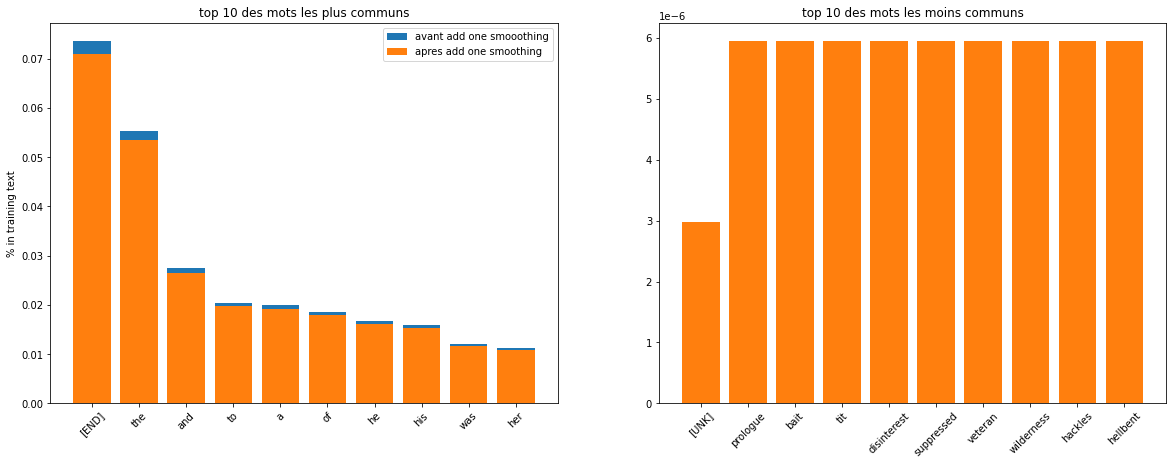

In [23]:

if __name__ == '__main__':

    print(UnigramCount.__doc__)
    count=UnigramCount('dataset/train.txt')

    model= UnigramModel(count)
    model.fit()
    #preprocessing('dev2_raw.txt','dev2.txt')
    eval_dev1 = UnigramCount('dataset/dev1.txt')
    eval_dev2 = UnigramCount('dataset/dev2.txt')
    print('average log_lik for dev1 : {0:.2f} and dev2 : {1:.2f}'.format(
    model.evaluate(eval_dev1),model.evaluate(eval_dev2)))
    model.plot()

In [ ]:
# comment tu vas 